In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


In [2]:
def to_polar_coords(xpix, ypix):
    dist = np.sqrt(xpix**2 + ypix**2)
    angles = np.arctan2(ypix, xpix)
    return dist, angles

In [6]:
def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

def color_thresh(img, rgb_thresh=(170, 170, 170)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select
    
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])



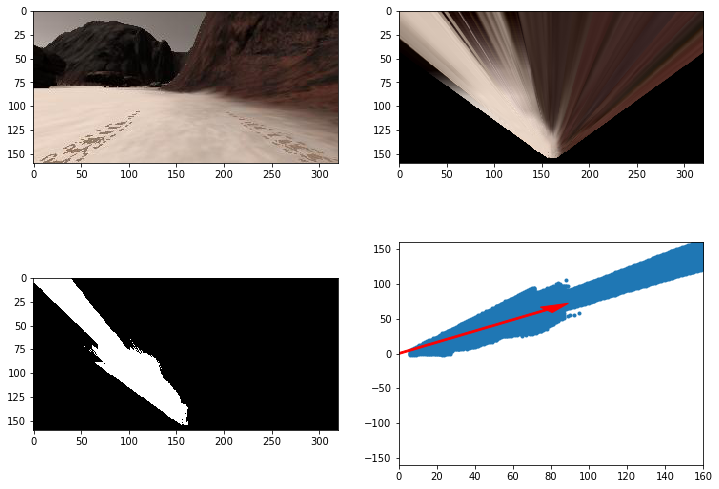

In [7]:
image = mpimg.imread('angle_example.jpg')
warped = perspect_transform(image, source, destination) # Perform perspective transform
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160)) # Threshold the warped image
xpix, ypix = rover_coords(colorsel)  # Convert to rover-centric coords
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(colorsel, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()